# 主旨
- 使用蒙地卡羅評價障礙選擇權
- 過程 : 
    1. 使用蒙地卡羅模擬n股價路徑
    2. 針對每個路徑計算其選擇權價值
    3. 將所有路徑的選擇權價值取平均，依據大數法則應近似母體平均，即選擇權期望價值

# 導入套件

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Step 1 模擬股價路徑

In [2]:
def stock_paths(S0: float, mu: float, sigma: float, T: float, n: int, I: int) :
    '''
    功能 : 模擬I條股價路徑(假設股價的隨機過程為幾何布朗運動 -> 股價服從對數常態分配)
    輸入 : 
        1. S0 : 期初股價，type=float
        2. mu : 股價報酬率的期望值，type=float
        3. sigma : 股價波動度，type=float
        4. T : 模擬股價時間長度(單位:年)，type=float
        5. n : 期數(該路徑下的股價數量)，type=int
        6. I : 模擬次數(路徑數量)，type=int
    輸出 :
        stock_paths : 模擬出來的股價路徑，type=np.array，dtype=np.float64
    '''
    # 計算參數
    dt = T / n

    # 模擬股價路徑
    z = np.random.normal(size=(I, n))  # 一次產生所有標準常態亂數(matrix size = I*n)
    t = np.arange(0, T, dt)  # 時間點vector，每個元素間隔為dt

    # 使用向量化操作計算所有股價路徑
    S = S0 * np.exp(np.cumsum((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z, axis=1))  
        # 使用np.cumsum累加至第t期的總變化倍數，再乘以期初股價S0即可算出第t期股價St
        # axis=1表累加方向為row(水平)

    # 在每條路徑的開頭插入期初股價
    stock_paths = np.insert(S, 0, S0, axis=1)  # axis=1表針對column方向進行操作

    return stock_paths

stock_paths(S0=100, mu=0.1, sigma=0.2, T=1.0, n=2, I=3)

array([[100.        ,  97.71062634, 107.45047156],
       [100.        , 107.1884557 ,  92.44330303],
       [100.        , 117.29619945, 105.91234223]])

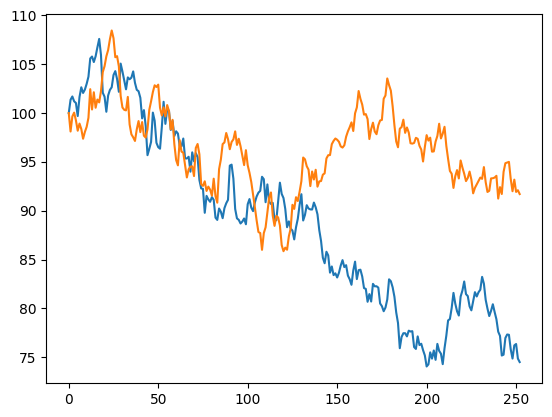

In [3]:
x = range(0,252+1)
y = np.transpose(stock_paths(S0=100, mu=0.1, sigma=0.2, T=1.0, n=252, I=2))
plt.plot(x,y)

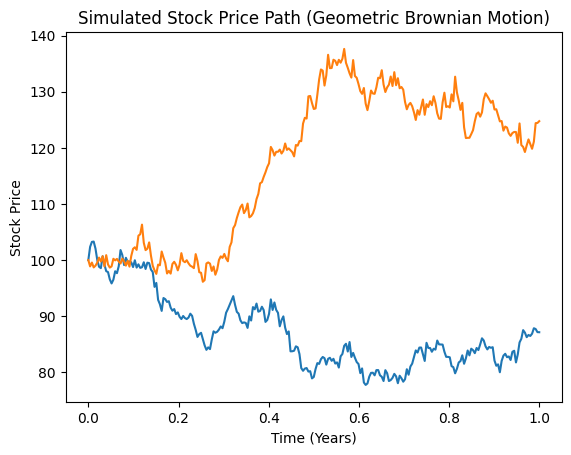

In [4]:
def simulate_stock_price(S0, sigma, T, n, I):
    dt = T / n
    t = np.linspace(0, T, n + 1)
    
    # 使用隨機漫步生成股價變化
    W = np.random.normal(0, np.sqrt(dt), size=(I, n))
    W = np.concatenate([np.zeros((I, 1)), np.cumsum(W, axis=1)], axis=1)
    
    # 幾何布朗運動
    S = S0 * np.exp(sigma * W)
    
    return t, S

# 模擬股價路徑
S0 = 100  # 初始股價
sigma = 0.2  # 波動率
T = 1  # 模擬的時間長度（年）
n = 252  # 模擬的時間步長（一個交易日）
I = 2

t, S = simulate_stock_price(S0, sigma, T, n, I)

# 繪製股價路徑
plt.plot(t, np.transpose(S))
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Path (Geometric Brownian Motion)')
plt.show()

# Step 2  計算選擇權價格

In [10]:
def Monte_eu_call(S0:float, K:int, r:float, mu:float, sigma:float, T:float, n:int, I:int) :
    '''
    功能 : 使用Monte Carlo模擬I條股價路徑，並用此計算歐式買權價格
    輸入 : 
        1. S0 : 期初股價，type=float
        2. K : 履約價，type=float 
        3. r : 無風險利率，type=float
        4. mu : 股價報酬率的期望值，type=float
        5. sigma : 股價波動度，type=float
        6. T : 模擬股價時間長度(單位:年)，type=float
        7. n : 期數(該路徑下的股價數量)，type=int
        8. I : 模擬次數(路徑數量)，type=int
    輸出 :
        stock_paths : 模擬出來的股價路徑，type=np.array，dtype=np.float64
    '''
    # 計算參數
    dt = T / n  # 每期間隔
    discount_factor = np.exp(-r*dt)  # 折現因子
        
    # 模擬股價路徑
    stock_path = stock_paths(S0, mu, sigma, T, n, I)
    
    # 計算期末option價值
    option_value = np.maximum( stock_path[:,-1] - K, 0 )
    
    # 計算期初價格
    option_value = option_value * discount_factor**(n)  # 計算option期末價值的現值
    
    # option價格
    option_price = np.mean(option_value)

    return option_price

Monte_eu_call(S0=100, K=100, r=0.05, mu=0.05, sigma=0.2, T=1.0, n=252, I=10000)

10.407456929359558

In [6]:
def Monte_eu_call2(S0:float, K:int, r:float, sigma:float, T:float, n:int, I:int) :
    '''
    功能 : 使用Monte Carlo模擬I條股價路徑，並用此計算歐式買權價格
    輸入 : 
        1. S0 : 期初股價，type=float
        2. K : 履約價，type=float 
        3. r : 無風險利率，type=float
        4. mu : 股價報酬率的期望值，type=float
        5. sigma : 股價波動度，type=float
        6. T : 模擬股價時間長度(單位:年)，type=float
        7. n : 期數(該路徑下的股價數量)，type=int
        8. I : 模擬次數(路徑數量)，type=int
    輸出 :
        stock_paths : 模擬出來的股價路徑，type=np.array，dtype=np.float64
    '''
    # 計算參數
    dt = T / n  # 每期間隔
    discount_factor = np.exp(-r*dt)  # 折現因子
        
    # 模擬股價路徑
    t, stock_path = simulate_stock_price(S0, sigma, T, n, I)
    
    # 計算期末option價值
    option_value = np.maximum( stock_path[:,-1] - K, 0 )
    
    # 計算期初價格
    option_value = option_value * discount_factor**(n)  # 計算option期末價值的現值
    
    # option價格
    option_price = np.mean(option_value)

    return option_price

Monte_eu_call2(S0=100, K=100, r=0.05, sigma=0.2, T=1.0, n=252, I=10000)

8.774410776484496